# reflectorch examples

Some examples illustrating reflectorch for internal usage. The file names from the beamtime (March 2023 Grenoble) are left unchanged.

# Init

In [2]:
from pathlib import Path

from h5py import File
import torch

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
from reflectorch import *
from reflectorch.inference import StandardPreprocessing, InferenceModel, MultilayerInferenceModel

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Standard parametrization (no Bragg peaks)

## Load the trained model

Available models:

In [13]:
list(Path('reflectorch').rglob('*.pt'))

[PosixPath('reflectorch/saved_models/model_l2q256_exp_2.pt'),
 PosixPath('reflectorch/saved_models/model_l2q256_exp_4.pt'),
 PosixPath('reflectorch/saved_models/model_l5q256_new_sub_1.pt'),
 PosixPath('reflectorch/saved_models/model_multilayer_test_1.pt'),
 PosixPath('reflectorch/saved_models/model_multilayer_test_2_2.pt'),
 PosixPath('reflectorch/saved_models/model_l2q256_exp_5.pt'),
 PosixPath('reflectorch/saved_models/model_l2q64_new_sub_1.pt'),
 PosixPath('reflectorch/saved_models/model_multilayer_test_2.pt'),
 PosixPath('reflectorch/saved_models/model_l2q256_exp_3.pt'),
 PosixPath('reflectorch/saved_models/model_l2q256_exp_3_02.pt')]

In [14]:
model = InferenceModel('l2q256_exp_5')

Model l2q256_exp_5 loaded. Number of parameters: 2.84 M


## Load processed data

In [19]:
data_folder = Path('/media/vladimir/data/XRR_beamtime')
file_path = data_folder / 'Alq3_insitu_1_run8.h5'

In [8]:
qs, curves, predicted_curves, params, scans = [], [], [], [], []

with File(file_path, 'r') as f:
    k_total_scan_nums = sorted(int(k.split('.')[0]) for k in f.keys())
    
    for scan in k_total_scan_nums[20:590]:
        group = f[f'{scan}.1']
        if 'xrr' in group.keys():
            scans.append(scan)
            curves.append(group['measurement']['corrected_intensity'][()])
            predicted_curves.append(group['measurement']['polished_intensity'][()])
            params.append(group['measurement']['polished_params'][()])
            qs.append(group['measurement']['raw_q'][()])

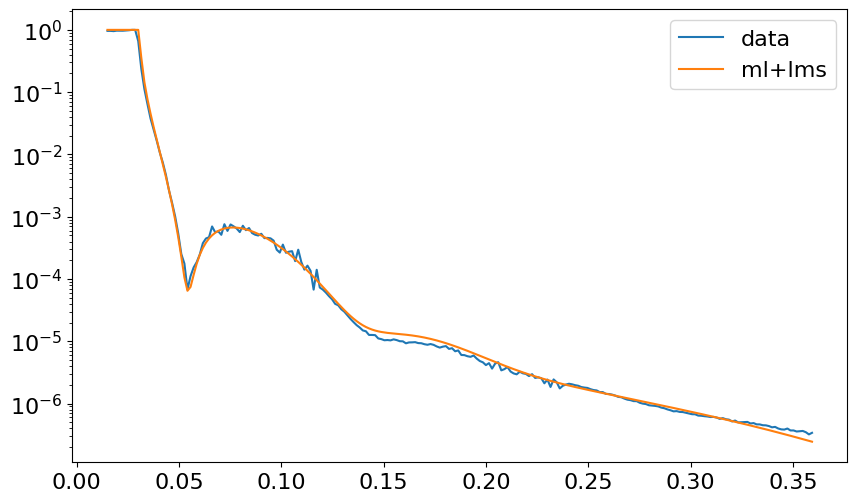

In [12]:
plt.semilogy(qs[0], curves[0], label='data')
plt.semilogy(qs[0], predicted_curves[0], label='ml+lms')
plt.legend()

Here we still do not have "preprocessed curves" since they are not interpolated to the model's internal q axis.
So let's do it:

In [53]:
from reflectorch.inference.preprocess_exp.interpolation import interp_reflectivity

In [55]:
curve = interp_reflectivity(model.q.cpu().numpy(), qs[0], curves[0])

## Make prediction on the processed data

Some priors around the parameters ...

In [38]:
init_params = params[0][:-1]
init_params

array([6.51343900e+01, 2.95445595e+01, 1.31016015e+01, 2.96201780e+00,
       1.02513368e-03, 1.07887982e+01, 1.93725623e+01, 1.90000000e+01])

In [59]:
min_bounds = init_params - np.ones_like(init_params)
max_bounds = init_params + np.ones_like(init_params)
min_bounds[0] -= 25
max_bounds[0] += 25
priors = np.clip(np.stack([min_bounds, max_bounds], -1), 0, None)
priors, priors.shape

(array([[39.13439001, 91.13439001],
        [28.54455951, 30.54455951],
        [12.10160146, 14.10160146],
        [ 1.9620178 ,  3.9620178 ],
        [ 0.        ,  1.00102513],
        [ 9.78879818, 11.78879818],
        [18.37256232, 20.37256232],
        [18.        , 20.        ]]),
 (8, 2))

In [60]:
res_dict = model.predict_from_preprocessed_curve(curve, priors)

Time for _qshift_prediction = 0.03 sec
Time for _polish_prediction = 0.05 sec


In [62]:
res_dict.keys()

dict_keys(['params', 'param_names', 'curve_predicted', 'sld_profile', 'sld_x_axis', 'params_polished', 'curve_polished', 'sld_profile_polished'])

In [63]:
res_dict['params']

array([57.79632939, 29.7596572 , 12.90979046,  2.13815241,  0.49722224,
       10.83291524, 19.58116664, 18.76362864])

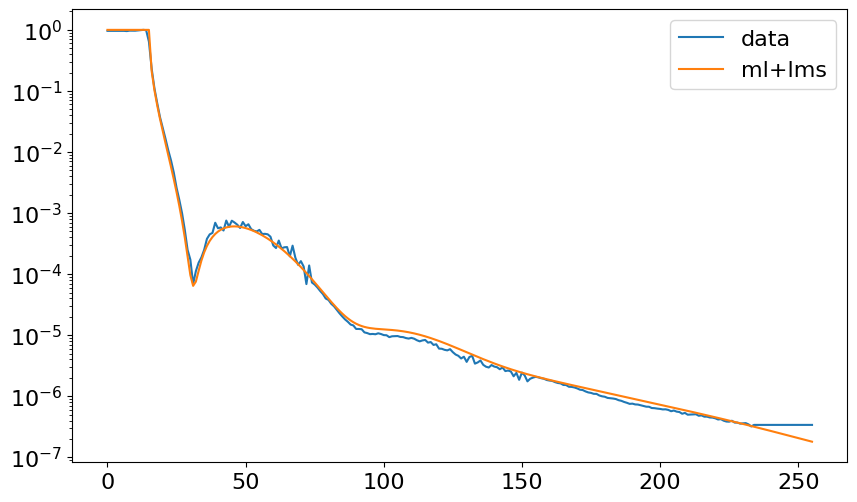

In [68]:
plt.semilogy(curve, label='data')
plt.semilogy(res_dict['curve_polished'], label='ml+lms')
plt.legend()

## Make prediction from raw data

In [73]:
with File('AlQ3_exsitu_samplingtests.h5', 'r') as f:
    group = f['18.1']
   
    intensity = group['measurement/mpx_cdte_22_eh1_roi2'][()]
    scattering_angle = group['measurement/gam'][()]
    attenuation = group['measurement/autof_eh1_transm'][()]
    b1, b2 = group['measurement/mpx_cdte_22_eh1_roi3'][()], group['measurement/mpx_cdte_22_eh1_roi4'][()]
    intensity = intensity - b1 - b2

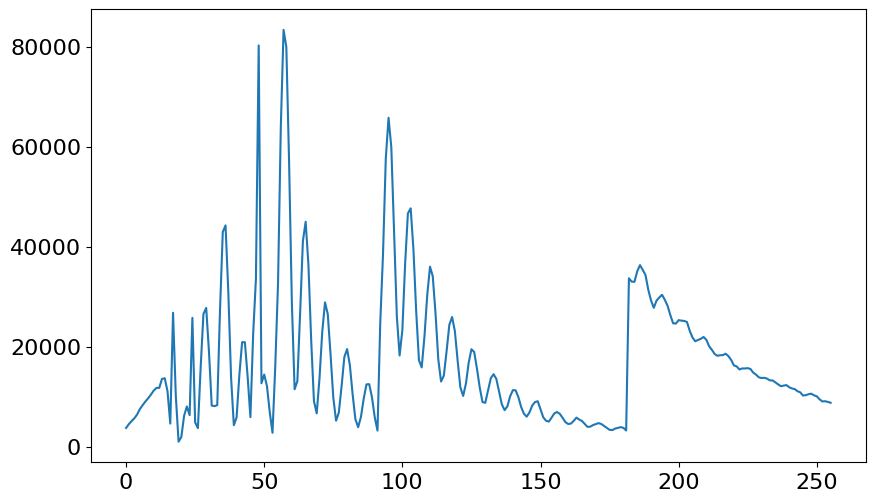

In [72]:
plt.plot(intensity)

In [74]:
priors = np.array([
    [200., 700.],
    [0.,  10.],
    [0.,  50.],
    [0.,  30.],
    [0.,  20.],
    [8.,  14.],
    [17.6, 17.8],
    [19.5, 20.1],
]) # some wide ranges

The simplest way is to set the preprocessing parameters once:

In [75]:
model.set_preprocessing_parameters(
    wavelength=0.729,
    beam_width=0.03,
    sample_length=10,
)

In [82]:
res = model.predict(
    intensity, 
    scattering_angle, 
    attenuation,
    priors, 
    fit_growth=False,
)

Time for preprocess = 0.00 sec
Time for _qshift_prediction = 0.03 sec
Time for _polish_prediction = 0.12 sec
Time for predict_from_preprocessed_curve = 0.17 sec
Time for everything = 0.17 sec


I cannot disable time recording with the current API, but it is pretty much obsolete and will be removed.

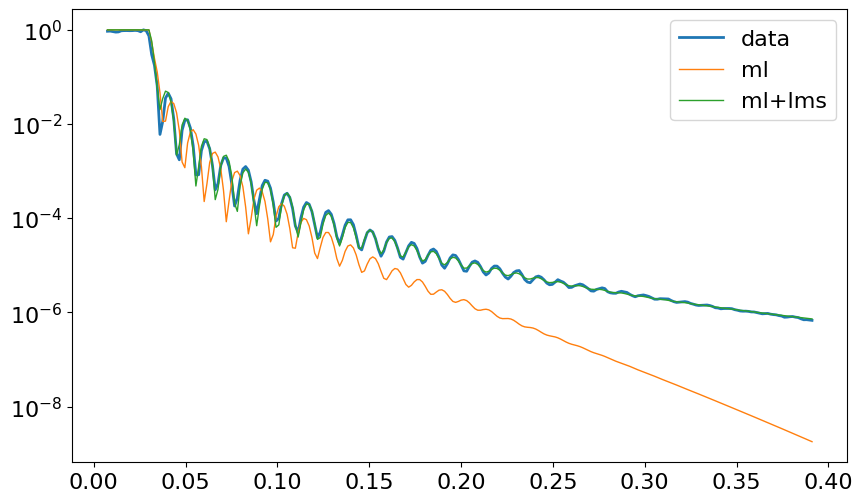

In [83]:
plt.semilogy(res['q_values'], res['curve'], label='data', lw=2)
plt.semilogy(res['q_values'], res['curve_predicted'], label='ml', lw=1)
plt.semilogy(res['q_values'], res['curve_polished'], label='ml+lms', lw=1)
plt.legend()

Maybe not the best looking example...

# Multilayer parametrization

## Load model

In [85]:
model = MultilayerInferenceModel('multilayer_test_2_2')

Model multilayer_test_2_2 loaded. Number of parameters: 8.30 M


## Load data

In [90]:
path = 'PTCDIC8_insitu_run2.h5'

scan = 11

with File(path, 'r') as f:
    group = f[f'{scan}.1/measurement']
    intensity = group['pilatus300k_roi2'][()]
    scattering_angle = group['gam'][()]
    attenuation = group['autof_eh1_transm'][()]
    b1, b2 = group['pilatus300k_roi3'][()], group['pilatus300k_roi4'][()]
    intensity = intensity - b1 - b2

## Preprocess (optional)

In [91]:
model.set_preprocessing_parameters(
    wavelength=0.729,
    beam_width=0.03,
    sample_length=10,
)

In [93]:
res = model.preprocess(intensity, scattering_angle, attenuation, )

In [94]:
res.keys()

dict_keys(['curve_interp', 'curve', 'q_values', 'q_interp', 'q_ratio'])

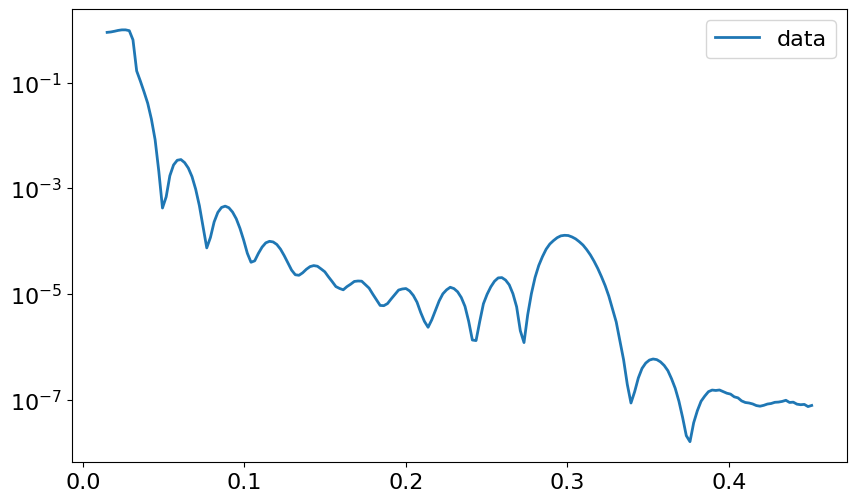

In [95]:
plt.semilogy(res['q_values'], res['curve'], label='data', lw=2)
plt.legend()

## Predict

In [96]:
res = model.predict(
    intensity, 
    scattering_angle, 
    attenuation,
    priors=None, # this model does not use priors, and it is already trained for quite narrow bounds
)

Time for preprocess = 0.00 sec
Time for _polish_prediction = 0.62 sec
Time for predict_from_preprocessed_curve = 0.65 sec
Time for everything = 0.65 sec


In [98]:
res.keys()

dict_keys(['curve_interp', 'curve', 'q_values', 'q_interp', 'q_ratio', 'params', 'param_names', 'curve_predicted', 'params_polished', 'curve_polished'])

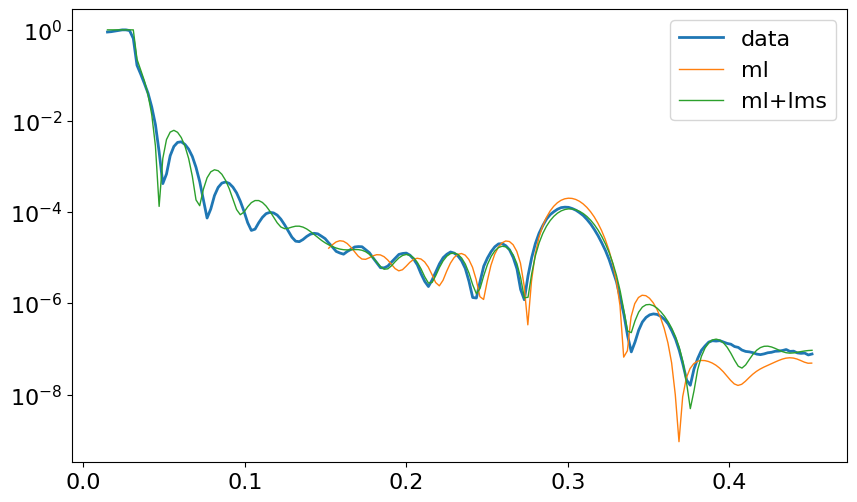

In [101]:
plt.semilogy(res['q_values'], res['curve'], label='data', lw=2)
plt.semilogy(res['q_interp'], res['curve_predicted'], label='ml', lw=1)
plt.semilogy(res['q_values'], res['curve_polished'], label='ml+lms', lw=1)
plt.legend()

Here the model inference & the fit are made on the subset of q points from 0.152 to 0.451 